# 주요 라이브러리 버전 확인

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


# 필요한 모듈 불러오기

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import time

# 데이터의 전처리

# Data Perprocess

## Data Load

* SessionID 대신 UserID 항목이 있다(명확한 1회 세션의 SessionID 미포함).   
* Rating 정보가 포함되어 있다. "직전에 봤던 영화에 대한 기호도"와 "비슷한 영화를 고르는 것"의 상관관계에 대해, 더하여 Rating이 낮은 데이터를 어떻게 처리할지 고민해야 한다.   
* Time 항목에는 UTC time이 포함되어 초단위 시간이 기재되어 있다.

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', 
                       header=None, usecols=[0, 1, 2, 3], 
                       names = ['UserId', 'ItemId', 'Rating', 'Time'], 
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, 
                       nrows=nrows)
    #data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 19.1 MB


In [6]:
data['Time'] = pd.to_datetime(data['Time'], unit='s') # Time 칼럼의 값을 Timestamp 형식으로 변형
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 26.7 MB


In [8]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## session length

In [9]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [10]:
user_length.median(), user_length.mean()


(96.0, 165.5975165562914)

userID 하나 당 평균 165편을 봤다.

In [11]:
user_length.min(), user_length.max()


(20, 2314)

In [12]:
user_length.quantile(0.999)


1343.181000000005

99%는 길이 1343 이하, 이를 크게 웃도는 길이는 어딘가 이상하므로 확인해본다.

In [13]:
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session].head(20)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
696250,4169,3841,2,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59


아래는 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화

In [14]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

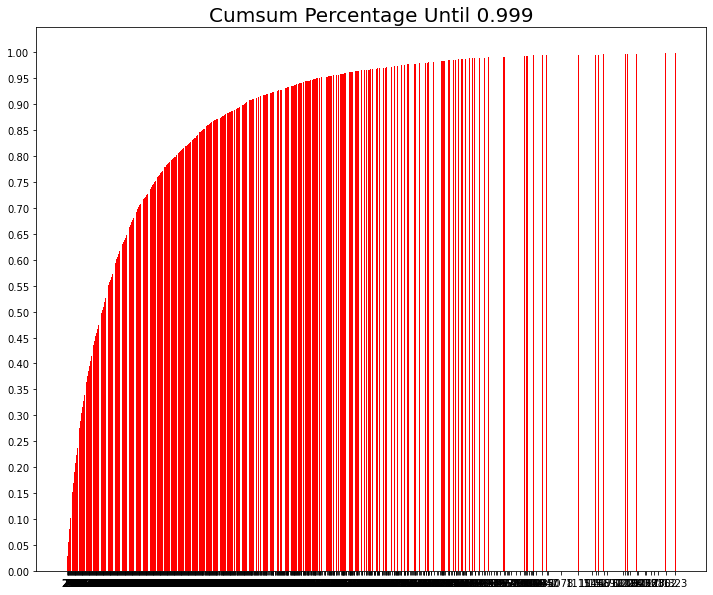

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## session time

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


2000년 4월 ~ 2003년 2월로 약 3년간의 데이터임을 확인.

In [17]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
#month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
#data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
#data

3년치 데이터를 전부 사용

## Data cleansing

In [19]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [20]:
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

165.5975165562914
269.88909875876953


* userID 하나 당 평균 165편을 시청했고  
* item은 하나 당 평균 269번 시청됐다.
그러므로 1번만 시청된 영화와 3번 이하만 시청한 userID 데이터를 제거한다.

In [21]:
data = cleanse_recursive(data, shortest=4, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Train / Valid / Test split

In [22]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [23]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [24]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [25]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978986
	 Users: 6038
	 Items: 3592
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12289
	 Users: 399
	 Items: 2624
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8820
	 Users: 339
	 Items: 2330
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



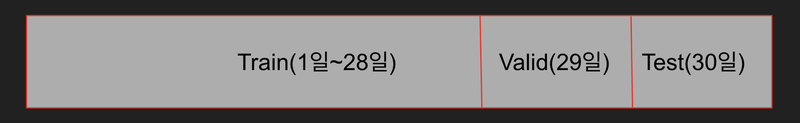

30일의 데이터 중에 마지막 180일은 분량은 test, 그 전 180일 분량은 valid 데이터로 사용

In [26]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [27]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 미니배치 구성

Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성한다.   
단, 위에서 Session단위를 어떻게 정의했느냐에 따라 Session-Parallel Mini-Batch가 굳이 필요하지 않을 수 있다.

# Data Pipeline

Session-Parallel Mini-Batch 구현

## SessionDataset

In [28]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [29]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [30]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978522, 978645, 978986], dtype=int32)

In [31]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

## SessionDataLoader

In [32]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [33]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head

<bound method NDFrame.head of          UserId  ItemId  Rating                Time  item_idx
31            1    3186       4 2000-12-31 22:00:19         0
22            1    1270       5 2000-12-31 22:00:55         1
27            1    1721       4 2000-12-31 22:00:55         2
37            1    1022       5 2000-12-31 22:00:55         3
24            1    2340       3 2000-12-31 22:01:43         4
...         ...     ...     ...                 ...       ...
1000019    6040    2917       4 2001-08-10 14:40:29      1248
999988     6040    1921       4 2001-08-10 14:41:04       370
1000172    6040    1784       3 2001-08-10 14:41:04        89
1000167    6040     161       3 2001-08-10 14:41:26       464
1000042    6040    1221       4 2001-08-20 13:44:15       430

[978986 rows x 5 columns]>

In [34]:
iter_ex = iter(tr_data_loader)

In [35]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# 모델 구성

# Modeling

## Evaluation Metric

In [36]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [38]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [39]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# 모델 학습

다양한 하이퍼파라미터를 변경해보며 검증하되 Recall, MRR등의 개념이 함께 관리될 수 있도록 한다.

## Model Training

In [40]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [41]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR을 확인한다.

## Inference

## 모델 학습

batch_size = 256   
hsz = 50   
drop_rate = 0.1   
lr = 0.001   

In [42]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546600    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3592)               183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:09<00:54,  1.39s/it]


	 - Recall@20 epoch 1: 0.067522
	 - MRR@20    epoch 1: 0.015245



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.32s/it]


	 - Recall@20 epoch 2: 0.104353
	 - MRR@20    epoch 2: 0.028057



Evaluation:  15%|█▌        | 7/46 [00:09<00:52,  1.36s/it]


	 - Recall@20 epoch 3: 0.112723
	 - MRR@20    epoch 3: 0.031883



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.32s/it]


	 - Recall@20 epoch 4: 0.116629
	 - MRR@20    epoch 4: 0.031511



Evaluation:  15%|█▌        | 7/46 [00:09<00:51,  1.33s/it]

	 - Recall@20 epoch 5: 0.118862
	 - MRR@20    epoch 5: 0.032645



accuracy와 loss가 조금씩 개선된다.

## 모델 평가

In [43]:
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:44,  1.45s/it]

	 - Recall@20: 0.126953
	 - MRR@20: 0.034395



# 회고

이번 Exploration은… 진행하면서 머리를 많이 싸맸다. 정의하는 함수도 하나같이 길고, 학습에 드는 시간도 길고, 눈앞에 마주했을 때 시각적, 정신적으로 오는 압박감이 어마어마했기 때문이다.     
    
* 요약: 하기 싫었다.    
    
그래서 미루기+데이터톤 진행으로 밀리기를 반복, 제출일 D-2시간 앞까지 왔다. 물론 그런 게 아니라도 11시 58~59분에 노드 제출하기를 밥 먹듯 해왔지만, 책상 앞에 앉은 나의 마음이 지금처럼 피눈물을 흘린 적은 없다. ‘데이터톤 열심히 했는데 노드 좀 안 해도 되는 거 아닌가’ 하는 보상심리까지 합쳐져 ‘지금이라도 이불에 들어가 모른 척 눈 감을까?’고민하기를 1시간. 그 끝에 어영부영이라도 이 자리에 앉아있는 내가 대견하다. 한솔아, 보고있니? 이모 잘하지?(사실 이모는 아니다. 장한솔 그는 89년생이기 때문이다.)    
루브릭 3개는 시간상 달성 못하겠지만, 수많은 오류를 넘고 넘어 모델이 돌아가고 있음에 감사하며 오늘 회고를 마친다.    

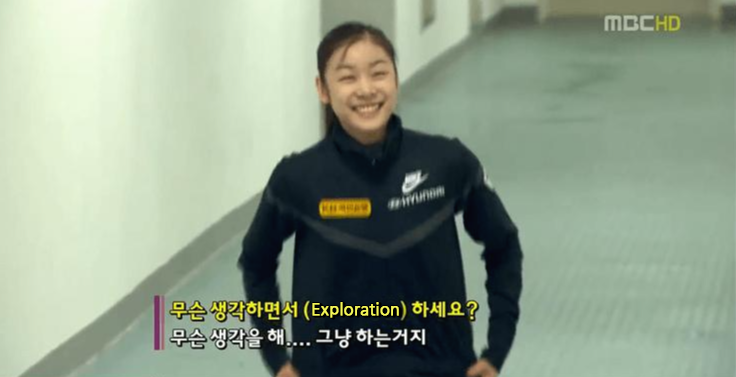